In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import numpy as np
import pickle
import sentencepiece as spm
from tqdm import tqdm

In [3]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.0.0')

In [4]:
!nvidia-smi

Fri Aug  7 13:46:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.64       Driver Version: 430.64       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000001:00:00.0 Off |                    0 |
| N/A   23C    P0    25W / 250W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
torch.cuda.set_device(0)

In [6]:
!pwd

/data/home/ubuntu/gaurav/in/fire/code-mixed-enma/language_model


In [7]:
path = Path('./')

In [8]:
def handle_all_caps(t: str) -> str:
    tokens = t.split()
    tokens = replace_all_caps(tokens)
    return ' '.join(tokens)

def handle_upper_case_first_letter(t: str) -> str:
    tokens = t.split()
    tokens = deal_caps(tokens)
    return ' '.join(tokens)

In [9]:
class CodeMixedMalayalamTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/mlen_spm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [10]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/mlen_spm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(25000)]

In [11]:
len(itos)

25000

In [12]:
itos[:20]

['xxunk',
 'xxbos',
 'xxeos',
 'xxpad',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 ',',
 'ൽ',
 '▁the',
 'ർ',
 '▁',
 'ൻ',
 's',
 '▁•',
 '▁of',
 'ൾ']

In [13]:
# 25,000 is the vocab size that we chose in sentencepiece
mlen_vocab = Vocab(itos)

In [14]:
tokenizer = Tokenizer(lang='mlen', tok_func=CodeMixedMalayalamTokenizer)

In [15]:
tokenizer.pre_rules.append(handle_all_caps)
tokenizer.pre_rules.append(handle_upper_case_first_letter)

In [16]:
tokenizer.special_cases, tokenizer.pre_rules, tokenizer.post_rules

(['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep'],
 [<function fastai.text.transform.fix_html>,
  <function fastai.text.transform.replace_rep>,
  <function fastai.text.transform.replace_wrep>,
  <function fastai.text.transform.spec_add_spaces>,
  <function fastai.text.transform.rm_useless_spaces>,
  <function __main__.handle_all_caps>,
  <function __main__.handle_upper_case_first_letter>],
 [<function fastai.text.transform.replace_all_caps>,
  <function fastai.text.transform.deal_caps>])

In [17]:
tokens = tokenizer.process_all(['Tell me about TOUR self, mujhe jaanna hai'])

In [18]:
''.join(tokens[0])

'▁xxmaj▁tell▁me▁about▁xxup▁tour▁self,▁mujhe▁jaanna▁hai'

In [19]:
path

PosixPath('.')

In [20]:
data_lm = TextLMDataBunch.from_folder(path=path/'../dataset_preparation', train='train_uncased' , valid='valid_uncased', vocab=mlen_vocab, tokenizer=tokenizer)

In [21]:
data_lm.batch_size

64

In [22]:
# data_lm.save()

In [23]:
data_lm.show_batch()

idx,text
0,"▁അര മണി ക്കൂ ർ ▁തുടർച്ചയായി ▁മസ്തിഷ്ക ് ക ത്തിന്റെ ▁വിദ്യ ു ത് ▁പ്രവർത്തനം ▁രേഖപ്പെടുത്ത ി ▁അവ ▁തരംഗ ▁രൂപത്തിൽ ▁ലഭ്യമാക്ക ുകയാണ് ▁ഇ . ഇ . ജി ▁യന്ത്ര ▁സംവിധാനം ▁ചെയ്യുന്നത് ▁. ▁x x bo s ▁ടാ ൻ ▁മല ാക ▁ഒരു ▁അദ്ധ്യാപക നും , ▁ഇന്തോനേഷ്യ ൻ ▁തത്ത്വചിന്ത കൻ , ▁സ്ട്ര ഗി ൾ ▁യൂണിയൻ ▁സ്ഥാപക ൻ , ▁സ്വതന്ത്ര ▁ഗറില്ല , ▁ഇന്തോനേഷ്യ ൻ ▁പോരാളി , ▁ഇന്തോനേഷ്യ ൻ ▁ദേശീയ ▁നായക ൻ , ▁മു ർ ബ ▁പാർട്ടി"
1,", ▁was ▁also ▁nickname d ▁"" ma cca be us "", ▁meaning ▁"" ham mer - like "". ▁kri . wa . ▁16 4- ൽ ▁uda ▁devalaya ▁pitich edukkukayu ▁atin ▁vigraha vi muk ta maki ▁parampragat may ▁yahuda radhan k ▁pun ർ pratishth ikkayu ▁cheitu . ▁yahudar ute ▁thirunal ay ▁' han u kka ' ▁i ▁sambhava tine ▁anu s maran a . ▁uda yumai ▁ottu ti ർ ppin ▁se"
2,s . ▁x x bo s ▁ഒരു ▁ഇംഗ്ലീഷ് ▁ബാലസാഹിത്യ ▁പുസ്തക ▁പരമ്പര യാണ് ▁ദ ▁ ഫേ മസ് ▁ ഫൈ വ് ▁ എന്നറിയപ്പെടുന്ന ▁കുറ്റ ാ ന് വേ ക ▁പരമ്പര . ▁വിഖ്യാത ▁ബാലസാഹിത്യ ▁ കർത്താവ ായ ▁എ നി ഡ് ▁ബ്ല ൈ റ്റ ൺ ▁ആണ് ▁ഈ ▁പരമ്പരയുടെ ▁സ് ര ഷ്ട ാവ ് . ▁എ ക്കാല ത്തേയും ▁മികച്ച ▁വി ൽ പന ▁വിജയം ▁കരസ്ഥമാക്കി യ ിട്ടുള്ള ▁പുസ്തക ▁പരമ്പര കളിൽ ▁ഒന്നാണ് ▁ദ ▁ ഫേ മസ് ▁ ഫൈ
3,"lukali ൽ ▁5 10 ▁ purush ൻ maru ▁50 1 ▁sti kalu ▁u ൾ ppetunnu . ▁76 . 48 ▁ % ▁saksharat yu ▁rekhappetutti t n . ▁about ▁60 .5 3% ▁of ▁the ▁population ▁of ▁the ▁village ▁is ▁scheduled ▁caste . ▁there ▁are ▁no ▁scheduled ▁tribes ▁in ▁this ▁area . ▁x x bo s ▁attitude s ▁and ▁policies ▁that ▁show ▁into ler ance ▁and ▁violence ▁to wards ▁foreigners , ▁foreigners"
4,ൽ ▁• ▁pel ▁• ▁pai ൻ ▁• ▁por ippuvant ▁• ▁potewak ▁• ▁poria ൻ ▁• ▁pont ൻ vak ▁• ▁pla ▁• ▁plash ▁• ▁ബദാം ▁• ▁ബാൽസ ▁• ▁ബ്ലാങ്ക മരം ▁• ▁മഞ്ചാടി ▁• ▁മഞ്ജ നാത്തി ▁• ▁മഞ്ഞക്കടമ്പ ് ▁• ▁മഞ്ഞക്കൊന്ന ▁• ▁മഞ്ഞ മന്ദാര ം ▁• ▁മട്ടി മരം ▁• ▁മണി മരുത് ▁• ▁മതഗിരി വേമ്പ് ▁• ▁മരോട്ടി മരം ▁• ▁മ ലങ്കാര ▁• ▁മലന്ത ുടലി ▁• ▁മലന്ത െങ്ങ് ▁• ▁മല മഞ്ചാടി ▁• ▁മലമ്പ രത്തി


In [24]:
len(data_lm.train_dl)

5926

In [25]:
len(data_lm.valid_dl)

2813

In [26]:
len(data_lm.vocab.itos)

25000

In [27]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=False)

In [28]:
gc.collect()

0

In [29]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(25000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(25000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=25000, bias=True)
    (output_dp): RNNDropout()
  )
)

In [30]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


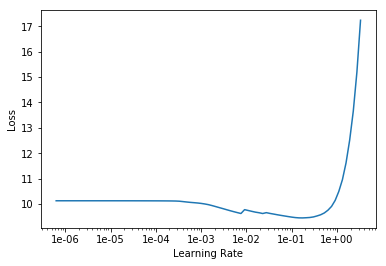

In [31]:
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(10, 1e-2, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='best_model')])

epoch,train_loss,valid_loss,accuracy,time
0,4.957266,4.958087,0.256315,11:41
1,4.931414,4.788522,0.263530,11:40
2,4.812356,4.733615,0.268380,11:39
3,4.635413,4.534071,0.288630,11:41
4,4.472992,4.364018,0.305372,11:39
5,4.293203,4.186538,0.325389,11:48
6,4.080749,4.002666,0.346900,11:38
7,3.941100,3.846199,0.366485,11:40
8,3.834695,3.742127,0.380040,11:39
9,3.631342,3.719126,0.383241,11:38


Better model found at epoch 0 with valid_loss value: 4.95808744430542.
Better model found at epoch 1 with valid_loss value: 4.788522243499756.
Better model found at epoch 2 with valid_loss value: 4.733615398406982.
Better model found at epoch 3 with valid_loss value: 4.534071445465088.
Better model found at epoch 4 with valid_loss value: 4.364018440246582.
Better model found at epoch 5 with valid_loss value: 4.186538219451904.
Better model found at epoch 6 with valid_loss value: 4.0026655197143555.
Better model found at epoch 7 with valid_loss value: 3.846198797225952.
Better model found at epoch 8 with valid_loss value: 3.7421274185180664.
Better model found at epoch 9 with valid_loss value: 3.719125986099243.


In [33]:
learn.load('best_model')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (52008 items)
x: LMTextList
▁x x bo s ▁electro en cephal ography ▁is ▁a ▁medical ▁examination ▁that ▁records ▁the ▁electrical ▁signal s ▁generate d ▁by ▁the ▁neu ron s ▁in ▁the ▁brain . ▁e . e . g . ▁it ▁was ▁invented ▁by ▁hans ▁ber ger ▁in ▁1929 . ▁തല യോ ടി നെ ▁ആവരണ ം ▁ചെയ്യുന്ന ▁തൊലി പ്പുറത്ത് ▁അനേകം ▁ഇലക്ട്രോ ഡുകൾ ▁ഘടിപ്പിച്ച ാണ് ▁വിദ്യ ു ത് ▁പ്രവർത്തനം ▁രേഖപ്പെടുത്ത ുന്നത് ▁. ഏ ക ദേശ ം ▁അര മണി ക്കൂ ർ ▁തുടർച്ചയായി ▁മസ്തിഷ്ക ് ക ത്തിന്റെ ▁വിദ്യ ു ത് ▁പ്രവർത്തനം ▁രേഖപ്പെടുത്ത ി ▁അവ ▁തരംഗ ▁രൂപത്തിൽ ▁ലഭ്യമാക്ക ുകയാണ് ▁ഇ . ഇ . ജി ▁യന്ത്ര ▁സംവിധാനം ▁ചെയ്യുന്നത് ▁.,▁x x bo s ▁ടാ ൻ ▁മല ാക ▁ഒരു ▁അദ്ധ്യാപക നും , ▁ഇന്തോനേഷ്യ ൻ ▁തത്ത്വചിന്ത കൻ , ▁സ്ട്ര ഗി ൾ ▁യൂണിയൻ ▁സ്ഥാപക ൻ , ▁സ്വതന്ത്ര ▁ഗറില്ല , ▁ഇന്തോനേഷ്യ ൻ ▁പോരാളി , ▁ഇന്തോനേഷ്യ ൻ ▁ദേശീയ ▁നായക ൻ , ▁മു ർ ബ ▁പാർട്ടി ▁എന്നീ ▁നിലകളിൽ ▁പ്രശസ്തനായ ിരുന്നു . ▁റിപ്പബ്ലിക്ക ് ▁ഓഫ് ▁ഇൻഡോ നേഷ്യ യുടെ ▁പിതാവ ായി ▁ഇന്തോനേഷ്യ ൻ ▁മാ ഗ സി ൻ ▁ടെ മ്പോ ▁ഇദ്ദേഹത്തെ ▁വിശേഷിപ്പിച്ച ിട്ടുണ്ട് ▁. ▁ta ൻ ▁mala k

In [34]:
TEXT = "മൈ നെയിം ഈസ്"
N_WORDS = 40
N_SENTENCES = 2

In [35]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.9) for _ in range(N_SENTENCES)))

മൈ നെയിം ഈസ് ഫ ു ൾ ▁രചിച്ച ▁നോവല ാണ് . ▁അതിന്റെ ▁കഥ ▁ ഛായാ ഗ്രാ ഹ ക ന്റെ ▁അന്വേഷണ ം ▁ കാട്ടി ▁ആണ് . ▁15 48 ▁ജനുവരി ▁2 ▁- നാണ് ▁ഈ ▁കാലയളവിൽ ▁ ശു ക്ര ൻ ▁വെളി ുന്നത് . ▁the ▁name ▁of ▁the
മൈ നെയിം ഈസ് ▁ ട്രോ മയില ിൻറെ ▁ഒരു ▁ക്ലാസ ിക്കൽ ▁സീരീസ ാണ് ▁അല്ലെങ്കിൽ ▁മാക് ▁ഒ ഡാ സിറ്റി . ▁പോ ണ്ടി ച്ചേരി യിൽ ▁നിന്നും ▁' ടാ ട്ട് ' ▁എന്ന ▁വാക്ക് ▁ആദ്യമായി ▁ഉപയോഗിച്ച ത് ▁ബ രി യാങ് മാൻ ▁ആണ് ▁. ▁i ▁vibhagatti ൽ ppet ▁europea


In [36]:
np.exp(3.719126)

41.228344784009494

In [37]:
defaults.device = torch.device('cpu')
learn.model.eval()
learn.export()

In [38]:
path

PosixPath('.')

In [39]:
encoder = get_model(learn.model)[0]

In [40]:
encoder.state_dict()['encoder.weight'].shape

torch.Size([25000, 400])

In [41]:
embeddings = encoder.state_dict()['encoder.weight']

In [42]:
embeddings = np.array(embeddings)

In [43]:
embeddings[0].shape

(400,)

In [44]:
df = pd.DataFrame(embeddings)

In [45]:
df.shape

(25000, 400)

In [46]:
df.to_csv('ulmfit_embeddings.tsv', sep='\t', index=False, header=False)

In [47]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,-0.327885,0.190964,-0.450726,-0.400183,-0.179856,-0.905958,0.086136,0.258753,0.011228,0.479137,...,1.033918,0.478133,1.662302,2.143348,-0.217533,-0.019658,-0.132753,0.461279,0.205089,-0.059317
1,-0.009385,0.114104,-0.465045,-0.064490,-0.040506,-0.154116,-0.172237,0.112455,-0.132561,0.226346,...,0.776205,0.152746,0.185799,0.633140,-0.194870,0.224456,0.048878,-0.047724,-0.027914,-0.107285
2,-0.009966,0.114034,-0.464695,-0.064950,-0.036445,-0.156636,-0.170471,0.112387,-0.135840,0.226637,...,0.776228,0.152809,0.185610,0.635955,-0.192446,0.224006,0.049066,-0.047447,-0.027741,-0.111416
3,-0.011370,0.114060,-0.464533,-0.062804,-0.036187,-0.160190,-0.171703,0.113987,-0.134248,0.228707,...,0.777494,0.153518,0.184058,0.632674,-0.195266,0.222179,0.049092,-0.047727,-0.028134,-0.105057
4,-0.009232,0.114384,-0.464089,-0.065354,-0.039551,-0.160816,-0.171405,0.112985,-0.135262,0.229380,...,0.777428,0.154529,0.185325,0.631566,-0.195310,0.223118,0.049453,-0.046619,-0.027919,-0.109792


In [48]:
df.shape

(25000, 400)

In [49]:
len(itos)

25000

In [50]:
df2 = pd.DataFrame(itos)

In [51]:
df2.head()

,0
0,xxunk
1,xxbos
2,xxeos
3,xxpad
4,xxfld


In [52]:
df2.shape

(25000, 1)

In [53]:
df2.to_csv('ulmfit_embeddings_metadata.tsv', sep='\t', index=False, header=False)

In [54]:
encoder.state_dict()['encoder.weight'][1]

tensor([-9.3854e-03,  1.1410e-01, -4.6505e-01, -6.4490e-02, -4.0506e-02,
        -1.5412e-01, -1.7224e-01,  1.1245e-01, -1.3256e-01,  2.2635e-01,
         1.4502e-02, -1.9071e-01,  1.1289e-02,  8.7088e-02,  2.6855e-01,
         8.8830e-02,  1.6969e-01,  6.8159e-02, -3.0119e-02, -1.9548e-01,
         2.5427e-01,  3.4280e-01, -2.8101e-02,  1.4417e-01,  4.7514e-01,
         6.7296e-02,  5.9158e-02, -3.2228e-01, -1.1577e-01, -2.6337e-02,
        -1.7773e-01, -1.3460e-01, -2.1282e-01,  2.8275e-01, -1.2585e-01,
        -5.5567e-02, -1.4942e-01,  1.4912e-01,  6.0518e-02,  1.3322e-01,
        -1.9021e-01, -2.2550e-01, -5.4514e-01,  8.4601e-02,  4.7392e-02,
         1.8211e-01, -3.4253e-01,  1.7223e-01, -1.4802e-01,  3.9464e-01,
         1.0101e-01, -5.5160e-02,  3.4626e-01, -5.5010e-01,  5.5077e-02,
         2.4130e-01,  5.7027e-02, -4.0931e-01, -2.6233e-01, -1.0415e-01,
         3.3878e-02, -3.0891e-01,  1.4016e-01, -2.5663e-01,  1.1356e-01,
        -1.4932e-01, -4.0894e-01,  1.4090e-01,  4.1